In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path().cwd().parent))

In [3]:
from typing import Tuple

import pandas as pd

from plotting import plot_ts
from load_dataset import Dataset
from model import TimeSeriesPredictor

### Какие ряды будем тестировать?

* длинный ряд с сезонностью  
* короткий ряд с сезонностью  
* короткий ряд с сезонностью и трендом  
* случайное блуждание  
* средне зашумленный ряд
* "шумный" ряд  

In [4]:
ds = Dataset('../data/dataset/')

In [5]:
long = ds['daily-min-temperatures.csv']

In [6]:
plot_ts(long)

Loading BokehJS ...

In [7]:
short_season = ds['hour_3019.csv'][300:]

In [8]:
plot_ts(short_season)

Loading BokehJS ...

In [9]:
short_season_trend = ds['international-airline-passengers.csv']

In [10]:
plot_ts(short_season_trend)

Loading BokehJS ...

In [11]:
random_walk = ds['dow_jones_0.csv']

In [12]:
plot_ts(random_walk)

Loading BokehJS ...

In [13]:
medium_noize = ds['hour_3426.csv'][300:]

In [14]:
plot_ts(medium_noize)

Loading BokehJS ...

In [15]:
full_noize = ds['day_1574.csv']

In [16]:
plot_ts(full_noize)

Loading BokehJS ...

### Какие модели будем тестировать?

* скользящее среднее
* экспоненциальное сглаживание
* autoArima
* линейная регрессия
* линейная регрессия с L1 регуляризацией (Ridge)
* RandomForeset
* градиентный бустинг


In [17]:
from estimators import RollingEstimator, ExponentialSmoothingEstimator
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

### По каким метрикам будем сравнивать?

* mse
* mae
* R2
* mape - если не будет ломаться на нулях
* mase

In [18]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

from metrics import mean_absolute_percentage_error as mape
from metrics import mase

### По какой методике будем тестировать?

* 70% трейн, 30% тест
* Out-of-sample, чтобы посмотреть как модель предсказывает "вдолгую"
* In-Sample, чтобы посмотреть как модель предсказывает на одну точку вперед
* Для поиска гиперпараметров можно делать кроссвалидацию на тесте по метрике mse

### Задание 1. Напишите функцию, разбивающую на train и test

In [19]:
def train_test_split(ts: pd.Series, ratio: float = 0.7) -> Tuple[pd.Series]:
    split_idx = int(len(ts) * ratio)
    ts_train, ts_test = ts[:split_idx], ts[split_idx:]
    # ваш код здесь
    return ts_train, ts_test

### Зададим соответствие гранулярностей для наших рядов.

In [20]:
granularity_mapping = {
    'long': 'P1D',
    'short_season': 'PT1H',
    'short_season_trend': 'P1M',
    'random_walk': 'P1D',
    'medium_noize': 'PT1H',
    'full_noize': 'P1D'
}

In [21]:
import math

from pandas._libs.tslibs.timestamps import Timestamp


def get_month_sin(timestamp: Timestamp) -> float:
    theta = timestamp.month * (2*math.pi / 12)
    return math.sin(theta)


def get_month_cos(timestamp: Timestamp) -> float:
    theta = timestamp.month * (2*math.pi / 12)
    return math.cos(theta)


def get_day_sin(timestamp: Timestamp) -> float:
    theta = timestamp.day * (2*math.pi / timestamp.days_in_month)
    return math.sin(theta)


def get_day_cos(timestamp: Timestamp) -> float:
    theta = timestamp.day * (2*math.pi / timestamp.days_in_month)
    return math.cos(theta)


def get_dayofweek_sin(timestamp: Timestamp) -> float:
    theta = timestamp.dayofweek * (2*math.pi / 7)
    return math.sin(theta)


def get_dayofweek_cos(timestamp: Timestamp) -> float:
    theta = timestamp.dayofweek * (2*math.pi / 7)
    return math.cos(theta)


def get_hour_sin(timestamp: Timestamp) -> float:
    theta = timestamp.hour * (2*math.pi / 24)
    return math.sin(theta)


def get_hour_cos(timestamp: Timestamp) -> float:
    theta = timestamp.hour * (2*math.pi / 24)
    return math.cos(theta)


def get_minute_sin(timestamp: Timestamp) -> float:
    theta = timestamp.minute * (2*math.pi / 60)
    return math.sin(theta)


def get_minute_cos(timestamp: Timestamp) -> float:
    theta = timestamp.minute * (2*math.pi / 60)
    return math.cos(theta)


datetime_mappers = {
    'month_sin': get_month_sin,
    'month_cos': get_month_cos,
    'day_sin': get_day_sin,
    'day_cos': get_day_cos,
    'dayofweek_sin': get_dayofweek_sin,
    'dayofweek_cos': get_dayofweek_cos,
    'hour_sin': get_hour_sin,
    'hour_cos': get_hour_cos,
    'minute_sin': get_minute_sin,
    'minute_cos': get_minute_cos,
}

### Задание 2. Напишите функцию, имплементирующую весь пайплайн обучения и прогноза через TimeSeriesPredictor.

* принмает на вход исходный ряд, гранулярность, количество лагов, модель, а также **kwargs, в которые мы будем передавать параметры модели

* разбивает ряд на train/test

* создает инстанс TimeSeriesPredictor с нужными параметрами

* обучает предиктор на трейне

* делает out_of_sample и in_sample прогноз

* возвращает train, test, in_sample, out_of_sample

In [24]:
def make_pipeline(
    ts: pd.Series,
    granularity: str,
    model: callable,
    num_lags=24,
    use_mappers=True,
    **kwargs
) -> Tuple[pd.Series]:
    
    train, test = train_test_split(ts)
    
    predictor = TimeSeriesPredictor(
        granularity=granularity,
        num_lags=num_lags,
        model=model,
    )
    
    if use_mappers:
        predictor.set_params(mappers=datetime_mappers)
        
    predictor.set_params(**kwargs)
    predictor.fit(train)
    
    in_sample = predictor.predict_batch(train, test)
    out_of_sample = predictor.predict_next(train, len(test))
    
   
    out_of_sample.index = test.index
    
    return train, test, in_sample, out_of_sample

### Задание 3. Напишите функцию, имплементирующую весь пайплайн обучения и прогноза через auto_arima

* функция должна принимать исходный временной ряд, период сезонности, параметры дифференцирования d, D и boolean параметр seasonal, данные параметры будут являться для нас гиперпараметрами, все остальное за нас должна найти auto_arima

* разбивает на train, test

* обучает arima на train при помощи вызова функции auto_arima из библиотеки pmdarima с переданными параметрами и со следующими зафиксированными параметрами: `max_p=3, max_q=3, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True`

* в качестве out_of_sample прогноза просто вызовите метод predict

* в качестве in_sample прогноза обучите модель заново на всём ряде методом `fit`, вызовите метод predict_in_sample и в качестве прогноза возьмите `in_sample_predictions(-len(test):)`

* возвращает train, test, in_sample, out_of_sample (не забудьте сделать их pd.Series с нужным индексом!!)

In [66]:
def make_pipeline_arima(ts: pd.Series, period: int, d: int = 1, D: int = 1, seasonal: bool = True) -> Tuple[pd.Series]:
    train, test = train_test_split(ts)
    
    arima_fit = auto_arima(
        train,
        max_p=2, max_q=2, m=period,
        seasonal=seasonal,
        d=d, D=D,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    
    out_of_sample = pd.Series(data=arima_fit.predict(len(test)), index=test.index)
    
    arima_fit.fit(ts)
    
    in_sample = pd.Series(arima_fit.predict_in_sample()[-len(test):], index=test.index)
    
    return in_sample, out_of_sample, [r2_score(test, in_sample), r2_score(test, out_of_sample)]

### Задание 4. Напишите функцию, имплементирующую поиск гиперпараметров по сетке. 

* функция должна принимать на вход ряд, гранулярность, модель, дефолтное количество лагов, сетку параметров (словарь)
* после написанного мной кода, функция должна с текущими параметрами запустить пайплайн (функция make_pipeline), получив таким образом прогнозы in_sample и out_of_sample
* посчитать mse для in_sample и out_of_sample прогноза, запомнить их в соответствующие словари
* вернуть лучшие параметры для in_sample и out_of_sample прогнозов

Замечания
* не забудьте, что в сетку параметров можно передавать также num_lags
* если в ряде ts_test есть пропуски, индекс прогноза out_of_sample будет не совпадать c индексом реальных данных, в таком случае, замените индекс out_of_sample прогноза индексом ts_test

In [42]:
from itertools import product

def hyperparameters_search(ts, granularity, model, num_lags, param_grid, verbose=False, use_mappers=True):
    
    statistics_in_sample, statistics_out_of_sample = {}, {}
    
    for param_tuple in product(*param_grid.values()):
        print('Прогон')
        params = dict(zip(param_grid.keys(), param_tuple))
        
        num_lags = params.pop('num_lags', None) or num_lags
        train, test, in_sample, out_of_sample = make_pipeline(
            ts, granularity, model, num_lags, use_mappers=use_mappers, **params)
        
        mse_in_sample = mse(test, in_sample)
        mae_in_sample = mae(test, in_sample)
        r2_score_in_sample = r2_score(test, in_sample)
        mase_in_sample = mase(in_sample, test)
        
        mse_out_of_sample = mse(test, out_of_sample)
        mae_out_of_sample = mae(test, out_of_sample)
        r2_score_out_of_sample = r2_score(test, out_of_sample)
        mase_out_of_sample = mase(out_of_sample, test)
        
        statistics_in_sample[param_tuple] = mse_in_sample
        statistics_out_of_sample[param_tuple] = mse_out_of_sample
        

        if verbose:
            print(f'Params are: {params}')
            print(
                f"""
                IN_SAMPLE
                mse: {mse(test, in_sample)},
                mae: {mae(test, in_sample)},
                r2: {r2_score(test, in_sample)},
                mase: {mase(in_sample, test)}
                ---------------------
                OUT_OF_SAMPLE
                mse: {mse(test, out_of_sample)},
                mae: {mae(test, out_of_sample)},
                r2: {r2_score(test, out_of_sample)},
                mase: {mase(out_of_sample, test)}
                """
            )
            plot_ts(train, test, in_sample, out_of_sample)
            
    
    best_in_sample = sorted(statistics_in_sample.items(), key=lambda x: x[1])[0]
    best_out_of_sample = sorted(statistics_out_of_sample.items(), key=lambda x: x[1])[0]
    
    best_in_sample = dict(zip(param_grid.keys(), best_in_sample[0]))
    best_out_of_sample = dict(zip(param_grid.keys(), best_out_of_sample[0]))
    
    
    if verbose:
        print(f"best in_sample params are {best_in_sample}")
        print(f"best out_of_sample params are {best_out_of_sample}")
    
    return best_in_sample, best_out_of_sample, [r2_score(test, in_sample), r2_score(test, out_of_sample)]

### Задание 5. "Прогоните" все алгоритмы на всех рядах и получите сводную таблицу результатов по всем метрикам, постройте также графики прогнозов. 

In [43]:
#Сильно гонять не буду - комп маломощный( сводную по r2 сделаю

In [44]:
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [45]:
from statsmodels.graphics.tsaplots import plot_acf

In [46]:
long = ds['daily-min-temperatures.csv']

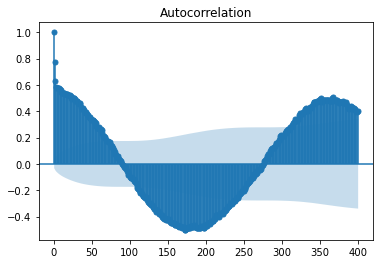

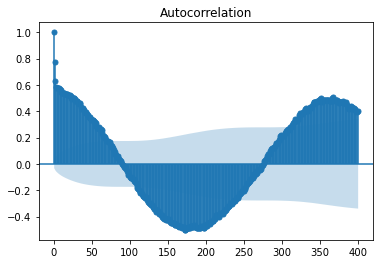

In [47]:
plot_acf(long, lags = 400)

In [48]:
param_grid = {'model__alpha':[i/10 for i in range(1,10,3)]}

In [50]:
best_in_sample, best_out_of_sample, result = hyperparameters_search(long, 'P1D', Ridge, 365, param_grid, verbose=False, use_mappers=True)

Прогон
Прогон
Прогон


In [54]:
res_df = pd.DataFrame()
res_df_tmp = pd.DataFrame({'ts':['long'], 'model':['Ridge'], 'best_in_sample':[best_in_sample], 'best_out_of_sample':[best_out_of_sample],
                          'r2_in':[result[0]], 'r2_out':[result[1]]})
res_df = pd.concat([res_df, res_df_tmp])

In [55]:
res_df

,ts,model,best_in_sample,best_out_of_sample,r2_in,r2_out
0,long,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.7},0.605741,0.277715


In [56]:
param_grid = {}

In [58]:
best_in_sample, best_out_of_sample, result = hyperparameters_search(long, 'P1D', LinearRegression, 365, param_grid, verbose=False, use_mappers=True)

Прогон


In [59]:
res_df_tmp = pd.DataFrame({'ts':['long'], 'model':['Linear'], 'best_in_sample':[best_in_sample], 'best_out_of_sample':[best_out_of_sample],
                          'r2_in':[result[0]], 'r2_out':[result[1]]})
res_df = pd.concat([res_df, res_df_tmp])
res_df

,ts,model,best_in_sample,best_out_of_sample,r2_in,r2_out
0,long,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.7},0.605741,0.277715
0,long,Linear,{},{},0.605648,0.277327


In [61]:

param_grid = {'model__n_estimators':[100,200],
             'model__max_depth':[5,10]}
best_in_sample, best_out_of_sample, result = hyperparameters_search(long, 'P1D', RandomForestRegressor, 365, param_grid, verbose=False, use_mappers=True)

Прогон
Прогон
Прогон
Прогон


In [62]:
res_df_tmp = pd.DataFrame({'ts':['long'], 'model':['RF'], 'best_in_sample':[best_in_sample], 'best_out_of_sample':[best_out_of_sample],
                          'r2_in':[result[0]], 'r2_out':[result[1]]})
res_df = pd.concat([res_df, res_df_tmp])
res_df

,ts,model,best_in_sample,best_out_of_sample,r2_in,r2_out
0,long,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.7},0.605741,0.277715
0,long,Linear,{},{},0.605648,0.277327
0,long,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 200, 'model__max_depth...",0.679706,0.460458


In [63]:
param_grid = {'model__n_estimators':[100,200],
             'model__max_depth':[5,10]}
best_in_sample, best_out_of_sample, result = hyperparameters_search(long, 'P1D', GradientBoostingRegressor, 365, param_grid, verbose=False, use_mappers=True)

Прогон
Прогон
Прогон
Прогон


In [64]:
res_df_tmp = pd.DataFrame({'ts':['long'], 'model':['GBR'], 'best_in_sample':[best_in_sample], 'best_out_of_sample':[best_out_of_sample],
                          'r2_in':[result[0]], 'r2_out':[result[1]]})
res_df = pd.concat([res_df, res_df_tmp])
res_df

,ts,model,best_in_sample,best_out_of_sample,r2_in,r2_out
0,long,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.7},0.605741,0.277715
0,long,Linear,{},{},0.605648,0.277327
0,long,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 200, 'model__max_depth...",0.679706,0.460458
0,long,GBR,"{'model__n_estimators': 100, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.640354,0.402724


In [69]:
# не смог за адекватное время посчитать 

long = long[-1000:] # ооочень долго считает
best_in_sample, best_out_of_sample, result  = make_pipeline_arima(long, period=365, d = 1, D = 1, seasonal= True) 

res_df_tmp = pd.DataFrame({'ts':['long'], 'model':['arima'], 'best_in_sample':[best_in_sample], 'best_out_of_sample':[best_out_of_sample],
                          'r2_in':[result[0]], 'r2_out':[result[1]]})
res_df = pd.concat([res_df, res_df_tmp])
res_df

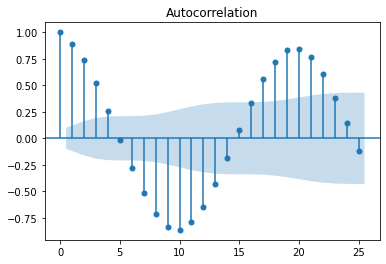

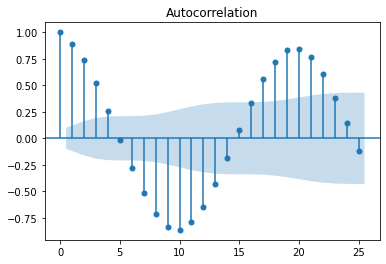

In [72]:
short_season = ds['hour_3019.csv'][300:]
plot_acf(short_season, lags = 25)

In [79]:
param_grid = {'model__alpha':[i/10 for i in range(1,10,3)]}
best_in_sample, best_out_of_sample, result = hyperparameters_search(long, 'PT1H', Ridge, 20, param_grid, verbose=False, use_mappers=True)
res_df_tmp = pd.DataFrame({'ts':['short'], 'model':['Ridge'], 'best_in_sample':[best_in_sample], 'best_out_of_sample':[best_out_of_sample],
                          'r2_in':[result[0]], 'r2_out':[result[1]]})
res_df = pd.concat([res_df, res_df_tmp])
res_df

Прогон
Прогон
Прогон


,ts,model,best_in_sample,best_out_of_sample,r2_in,r2_out
0,long,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.7},0.605741,0.277715
0,long,Linear,{},{},0.605648,0.277327
0,long,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 200, 'model__max_depth...",0.679706,0.460458
0,long,GBR,"{'model__n_estimators': 100, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.640354,0.402724
0,short,Ridge,{'model__alpha': 0.1},{'model__alpha': 0.7},0.582263,-1.533148


In [80]:
param_grid = {}
best_in_sample, best_out_of_sample, result = hyperparameters_search(long, 'PT1H', LinearRegression, 20, param_grid, verbose=False, use_mappers=True)
res_df_tmp = pd.DataFrame({'ts':['short'], 'model':['Linear'], 'best_in_sample':[best_in_sample], 'best_out_of_sample':[best_out_of_sample],
                          'r2_in':[result[0]], 'r2_out':[result[1]]})
res_df = pd.concat([res_df, res_df_tmp])
res_df

Прогон


,ts,model,best_in_sample,best_out_of_sample,r2_in,r2_out
0,long,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.7},0.605741,0.277715
0,long,Linear,{},{},0.605648,0.277327
0,long,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 200, 'model__max_depth...",0.679706,0.460458
0,long,GBR,"{'model__n_estimators': 100, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.640354,0.402724
0,short,Ridge,{'model__alpha': 0.1},{'model__alpha': 0.7},0.582263,-1.533148
0,short,Linear,{},{},0.582352,-1.533738


In [84]:
param_grid = {'model__n_estimators':[100,200],
             'model__max_depth':[5,10]}
best_in_sample, best_out_of_sample, result = hyperparameters_search(long, 'PT1H', RandomForestRegressor, 20, param_grid, verbose=False, use_mappers=True)
res_df_tmp = pd.DataFrame({'ts':['short'], 'model':['RF'], 'best_in_sample':[best_in_sample], 'best_out_of_sample':[best_out_of_sample],
                          'r2_in':[result[0]], 'r2_out':[result[1]]})
res_df = pd.concat([res_df, res_df_tmp])
res_df

Прогон
Прогон
Прогон
Прогон


,ts,model,best_in_sample,best_out_of_sample,r2_in,r2_out
0,long,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.7},0.605741,0.277715
0,long,Linear,{},{},0.605648,0.277327
0,long,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 200, 'model__max_depth...",0.679706,0.460458
0,long,GBR,"{'model__n_estimators': 100, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.640354,0.402724
0,short,Ridge,{'model__alpha': 0.1},{'model__alpha': 0.7},0.582263,-1.533148
0,short,Linear,{},{},0.582352,-1.533738
0,short,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.574257,-3.510385


In [85]:
param_grid = {'model__n_estimators':[100,200],
             'model__max_depth':[5,3]}
best_in_sample, best_out_of_sample, result = hyperparameters_search(long, 'PT1H', GradientBoostingRegressor, 20, param_grid, verbose=False, use_mappers=True)
res_df_tmp = pd.DataFrame({'ts':['short'], 'model':['GBR'], 'best_in_sample':[best_in_sample], 'best_out_of_sample':[best_out_of_sample],
                          'r2_in':[result[0]], 'r2_out':[result[1]]})
res_df = pd.concat([res_df, res_df_tmp])
res_df

Прогон
Прогон
Прогон
Прогон


,ts,model,best_in_sample,best_out_of_sample,r2_in,r2_out
0,long,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.7},0.605741,0.277715
0,long,Linear,{},{},0.605648,0.277327
0,long,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 200, 'model__max_depth...",0.679706,0.460458
0,long,GBR,"{'model__n_estimators': 100, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.640354,0.402724
0,short,Ridge,{'model__alpha': 0.1},{'model__alpha': 0.7},0.582263,-1.533148
0,short,Linear,{},{},0.582352,-1.533738
0,short,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.574257,-3.510385
0,short,GBR,"{'model__n_estimators': 100, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.537800,-3.391875


In [87]:

best_in_sample, best_out_of_sample, result  = make_pipeline_arima(long, period=20, d = 1, D = 0, seasonal= True) 
best_in_sample, best_out_of_sample = {}, {}
res_df_tmp = pd.DataFrame({'ts':['short'], 'model':['arima'], 'best_in_sample':[best_in_sample], 'best_out_of_sample':[best_out_of_sample],
                          'r2_in':[result[0]], 'r2_out':[result[1]]})
res_df = pd.concat([res_df, res_df_tmp])
res_df

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[20] intercept   : AIC=3168.241, Time=2.69 sec
 ARIMA(0,1,0)(0,0,0)[20] intercept   : AIC=3332.968, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[20] intercept   : AIC=3304.603, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[20] intercept   : AIC=3260.894, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[20]             : AIC=3330.968, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[20] intercept   : AIC=3166.351, Time=2.22 sec
 ARIMA(2,1,2)(0,0,0)[20] intercept   : AIC=3164.366, Time=0.76 sec
 ARIMA(2,1,2)(1,0,0)[20] intercept   : AIC=3166.350, Time=2.20 sec
 ARIMA(1,1,2)(0,0,0)[20] intercept   : AIC=3163.528, Time=0.25 sec
 ARIMA(1,1,2)(1,0,0)[20] intercept   : AIC=3165.501, Time=0.73 sec
 ARIMA(1,1,2)(0,0,1)[20] intercept   : AIC=3165.502, Time=0.77 sec
 ARIMA(1,1,2)(1,0,1)[20] intercept   : AIC=3167.297, Time=1.71 sec
 ARIMA(0,1,2)(0,0,0)[20] intercept   : AIC=3167.298, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[20] intercept   : AIC=3167.456, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0

,ts,model,best_in_sample,best_out_of_sample,r2_in,r2_out
0,long,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.7},0.605741,0.277715
0,long,Linear,{},{},0.605648,0.277327
0,long,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 200, 'model__max_depth...",0.679706,0.460458
0,long,GBR,"{'model__n_estimators': 100, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.640354,0.402724
0,short,Ridge,{'model__alpha': 0.1},{'model__alpha': 0.7},0.582263,-1.533148
0,short,Linear,{},{},0.582352,-1.533738
0,short,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.574257,-3.510385
0,short,GBR,"{'model__n_estimators': 100, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.537800,-3.391875
0,short,arima,1981-01-01 1990-03-07 17.037936 1990-03-08 ...,1981-01-01 1990-03-07 17.104648 1990-03-08 ...,0.575046,-3.497828
0,short,arima,{},{},0.575046,-3.497828


In [91]:
random_walk = ds['dow_jones_0.csv']

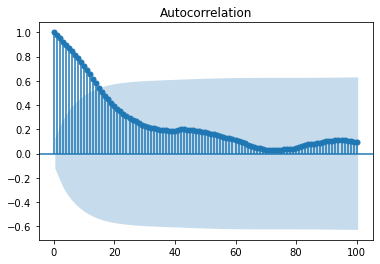

In [95]:
plot_acf(random_walk, lags = 100);

In [98]:
param_grid = {'model__alpha':[i/10 for i in range(1,10,3)]}
best_in_sample, best_out_of_sample, result = hyperparameters_search(random_walk, 'P1D', Ridge, 10, param_grid, verbose=False, use_mappers=True)
res_df_tmp = pd.DataFrame({'ts':['random_walk'], 'model':['Ridge'], 'best_in_sample':[best_in_sample], 'best_out_of_sample':[best_out_of_sample],
                          'r2_in':[result[0]], 'r2_out':[result[1]]})
res_df = pd.concat([res_df, res_df_tmp])
res_df

Прогон
Прогон
Прогон


,ts,model,best_in_sample,best_out_of_sample,r2_in,r2_out
0,long,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.7},0.605741,0.277715
0,long,Linear,{},{},0.605648,0.277327
0,long,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 200, 'model__max_depth...",0.679706,0.460458
0,long,GBR,"{'model__n_estimators': 100, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.640354,0.402724
0,short,Ridge,{'model__alpha': 0.1},{'model__alpha': 0.7},0.582263,-1.533148
0,short,Linear,{},{},0.582352,-1.533738
0,short,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.574257,-3.510385
0,short,arima,{},{},0.575046,-3.497828
0,random_walk,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.1},0.859543,-136.844976


In [99]:
param_grid = {}
best_in_sample, best_out_of_sample, result = hyperparameters_search(random_walk, 'P1D', LinearRegression, 10, param_grid, verbose=False, use_mappers=True)
res_df_tmp = pd.DataFrame({'ts':['random_walk'], 'model':['Linear'], 'best_in_sample':[best_in_sample], 'best_out_of_sample':[best_out_of_sample],
                          'r2_in':[result[0]], 'r2_out':[result[1]]})
res_df = pd.concat([res_df, res_df_tmp])
res_df

Прогон


,ts,model,best_in_sample,best_out_of_sample,r2_in,r2_out
0,long,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.7},0.605741,0.277715
0,long,Linear,{},{},0.605648,0.277327
0,long,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 200, 'model__max_depth...",0.679706,0.460458
0,long,GBR,"{'model__n_estimators': 100, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.640354,0.402724
0,short,Ridge,{'model__alpha': 0.1},{'model__alpha': 0.7},0.582263,-1.533148
0,short,Linear,{},{},0.582352,-1.533738
0,short,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.574257,-3.510385
0,short,arima,{},{},0.575046,-3.497828
0,random_walk,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.1},0.859543,-136.844976
0,random_walk,Linear,{},{},0.857620,-135.392182


In [100]:
param_grid = {'model__n_estimators':[100,200],
             'model__max_depth':[5,10]}
best_in_sample, best_out_of_sample, result = hyperparameters_search(random_walk, 'P1D', RandomForestRegressor, 10, param_grid, verbose=False, use_mappers=True)
res_df_tmp = pd.DataFrame({'ts':['random_walk'], 'model':['RF'], 'best_in_sample':[best_in_sample], 'best_out_of_sample':[best_out_of_sample],
                          'r2_in':[result[0]], 'r2_out':[result[1]]})
res_df = pd.concat([res_df, res_df_tmp])
res_df

Прогон
Прогон
Прогон
Прогон


,ts,model,best_in_sample,best_out_of_sample,r2_in,r2_out
0,long,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.7},0.605741,0.277715
0,long,Linear,{},{},0.605648,0.277327
0,long,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 200, 'model__max_depth...",0.679706,0.460458
0,long,GBR,"{'model__n_estimators': 100, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.640354,0.402724
0,short,Ridge,{'model__alpha': 0.1},{'model__alpha': 0.7},0.582263,-1.533148
0,short,Linear,{},{},0.582352,-1.533738
0,short,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.574257,-3.510385
0,short,arima,{},{},0.575046,-3.497828
0,random_walk,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.1},0.859543,-136.844976
0,random_walk,Linear,{},{},0.857620,-135.392182


In [101]:
param_grid = {'model__n_estimators':[100,200],
             'model__max_depth':[5,3]}
best_in_sample, best_out_of_sample, result = hyperparameters_search(random_walk, 'P1D', GradientBoostingRegressor, 10, param_grid, verbose=False, use_mappers=True)
res_df_tmp = pd.DataFrame({'ts':['random_walk'], 'model':['GBR'], 'best_in_sample':[best_in_sample], 'best_out_of_sample':[best_out_of_sample],
                          'r2_in':[result[0]], 'r2_out':[result[1]]})
res_df = pd.concat([res_df, res_df_tmp])
res_df

Прогон
Прогон
Прогон
Прогон


,ts,model,best_in_sample,best_out_of_sample,r2_in,r2_out
0,long,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.7},0.605741,0.277715
0,long,Linear,{},{},0.605648,0.277327
0,long,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 200, 'model__max_depth...",0.679706,0.460458
0,long,GBR,"{'model__n_estimators': 100, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.640354,0.402724
0,short,Ridge,{'model__alpha': 0.1},{'model__alpha': 0.7},0.582263,-1.533148
0,short,Linear,{},{},0.582352,-1.533738
0,short,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.574257,-3.510385
0,short,arima,{},{},0.575046,-3.497828
0,random_walk,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.1},0.859543,-136.844976
0,random_walk,Linear,{},{},0.857620,-135.392182


In [102]:
best_in_sample, best_out_of_sample, result  = make_pipeline_arima(long, period=20, d = 0, D = 0, seasonal= False) 
best_in_sample, best_out_of_sample = {}, {}
res_df_tmp = pd.DataFrame({'ts':['random_walk'], 'model':['arima'], 'best_in_sample':[best_in_sample], 'best_out_of_sample':[best_out_of_sample],
                          'r2_in':[result[0]], 'r2_out':[result[1]]})
res_df = pd.concat([res_df, res_df_tmp])
res_df

C:\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (20) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3171.899, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5492.073, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3333.547, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4726.097, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3175.655, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3175.822, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3266.719, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3168.989, Time=0.57 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3172.502, Time=0.40 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3172.944, Time=0.54 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3246.008, Time=0.18 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 2.529 seconds


,ts,model,best_in_sample,best_out_of_sample,r2_in,r2_out
0,long,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.7},0.605741,0.277715
0,long,Linear,{},{},0.605648,0.277327
0,long,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 200, 'model__max_depth...",0.679706,0.460458
0,long,GBR,"{'model__n_estimators': 100, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.640354,0.402724
0,short,Ridge,{'model__alpha': 0.1},{'model__alpha': 0.7},0.582263,-1.533148
0,short,Linear,{},{},0.582352,-1.533738
0,short,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.574257,-3.510385
0,short,arima,{},{},0.575046,-3.497828
0,random_walk,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.1},0.859543,-136.844976
0,random_walk,Linear,{},{},0.857620,-135.392182


In [103]:
medium_noize = ds['hour_3426.csv'][300:]

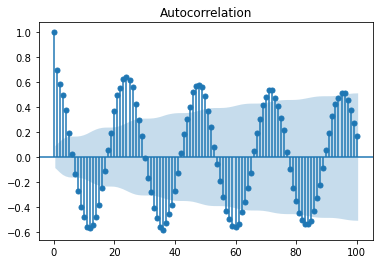

In [104]:
plot_acf(medium_noize, lags = 100);

In [105]:
param_grid = {'model__alpha':[i/10 for i in range(1,10,3)]}
best_in_sample, best_out_of_sample, result = hyperparameters_search(medium_noize, 'PT1H', Ridge, 24, param_grid, verbose=False, use_mappers=True)
res_df_tmp = pd.DataFrame({'ts':['medium_noize'], 'model':['Ridge'], 'best_in_sample':[best_in_sample], 'best_out_of_sample':[best_out_of_sample],
                          'r2_in':[result[0]], 'r2_out':[result[1]]})
res_df = pd.concat([res_df, res_df_tmp])
res_df

Прогон
Прогон
Прогон


,ts,model,best_in_sample,best_out_of_sample,r2_in,r2_out
0,long,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.7},0.605741,0.277715
0,long,Linear,{},{},0.605648,0.277327
0,long,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 200, 'model__max_depth...",0.679706,0.460458
0,long,GBR,"{'model__n_estimators': 100, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.640354,0.402724
0,short,Ridge,{'model__alpha': 0.1},{'model__alpha': 0.7},0.582263,-1.533148
0,short,Linear,{},{},0.582352,-1.533738
0,short,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.574257,-3.510385
0,short,arima,{},{},0.575046,-3.497828
0,random_walk,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.1},0.859543,-136.844976
0,random_walk,Linear,{},{},0.857620,-135.392182


In [106]:
param_grid = {}
best_in_sample, best_out_of_sample, result = hyperparameters_search(medium_noize, 'PT1H', LinearRegression, 24, param_grid, verbose=False, use_mappers=True)
res_df_tmp = pd.DataFrame({'ts':['medium_noize'], 'model':['Linear'], 'best_in_sample':[best_in_sample], 'best_out_of_sample':[best_out_of_sample],
                          'r2_in':[result[0]], 'r2_out':[result[1]]})
res_df = pd.concat([res_df, res_df_tmp])
res_df

Прогон


,ts,model,best_in_sample,best_out_of_sample,r2_in,r2_out
0,long,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.7},0.605741,0.277715
0,long,Linear,{},{},0.605648,0.277327
0,long,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 200, 'model__max_depth...",0.679706,0.460458
0,long,GBR,"{'model__n_estimators': 100, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.640354,0.402724
0,short,Ridge,{'model__alpha': 0.1},{'model__alpha': 0.7},0.582263,-1.533148
0,short,Linear,{},{},0.582352,-1.533738
0,short,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.574257,-3.510385
0,short,arima,{},{},0.575046,-3.497828
0,random_walk,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.1},0.859543,-136.844976
0,random_walk,Linear,{},{},0.857620,-135.392182


In [107]:
param_grid = {'model__n_estimators':[100,200],
             'model__max_depth':[5,10]}
best_in_sample, best_out_of_sample, result = hyperparameters_search(medium_noize, 'PT1H', RandomForestRegressor, 24, param_grid, verbose=False, use_mappers=True)
res_df_tmp = pd.DataFrame({'ts':['medium_noize'], 'model':['RF'], 'best_in_sample':[best_in_sample], 'best_out_of_sample':[best_out_of_sample],
                          'r2_in':[result[0]], 'r2_out':[result[1]]})
res_df = pd.concat([res_df, res_df_tmp])
res_df

Прогон
Прогон
Прогон
Прогон


,ts,model,best_in_sample,best_out_of_sample,r2_in,r2_out
0,long,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.7},0.605741,0.277715
0,long,Linear,{},{},0.605648,0.277327
0,long,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 200, 'model__max_depth...",0.679706,0.460458
0,long,GBR,"{'model__n_estimators': 100, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.640354,0.402724
0,short,Ridge,{'model__alpha': 0.1},{'model__alpha': 0.7},0.582263,-1.533148
0,short,Linear,{},{},0.582352,-1.533738
0,short,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.574257,-3.510385
0,short,arima,{},{},0.575046,-3.497828
0,random_walk,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.1},0.859543,-136.844976
0,random_walk,Linear,{},{},0.857620,-135.392182


In [108]:
param_grid = {'model__n_estimators':[100,200],
             'model__max_depth':[5,3]}
best_in_sample, best_out_of_sample, result = hyperparameters_search(medium_noize, 'PT1H', GradientBoostingRegressor, 24, param_grid, verbose=False, use_mappers=True)
res_df_tmp = pd.DataFrame({'ts':['medium_noize'], 'model':['GBR'], 'best_in_sample':[best_in_sample], 'best_out_of_sample':[best_out_of_sample],
                          'r2_in':[result[0]], 'r2_out':[result[1]]})
res_df = pd.concat([res_df, res_df_tmp])
res_df

Прогон
Прогон
Прогон
Прогон


,ts,model,best_in_sample,best_out_of_sample,r2_in,r2_out
0,long,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.7},0.605741,0.277715
0,long,Linear,{},{},0.605648,0.277327
0,long,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 200, 'model__max_depth...",0.679706,0.460458
0,long,GBR,"{'model__n_estimators': 100, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.640354,0.402724
0,short,Ridge,{'model__alpha': 0.1},{'model__alpha': 0.7},0.582263,-1.533148
0,short,Linear,{},{},0.582352,-1.533738
0,short,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.574257,-3.510385
0,short,arima,{},{},0.575046,-3.497828
0,random_walk,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.1},0.859543,-136.844976
0,random_walk,Linear,{},{},0.857620,-135.392182


In [109]:
best_in_sample, best_out_of_sample, result  = make_pipeline_arima(medium_noize, period=24, d = 1, D = 0, seasonal= True) 
best_in_sample, best_out_of_sample = {}, {}
res_df_tmp = pd.DataFrame({'ts':['medium_noize'], 'model':['arima'], 'best_in_sample':[best_in_sample], 'best_out_of_sample':[best_out_of_sample],
                          'r2_in':[result[0]], 'r2_out':[result[1]]})
res_df = pd.concat([res_df, res_df_tmp])
res_df

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=3210.241, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=3176.840, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=3163.025, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=3208.242, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=3166.532, Time=0.08 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(0,1,1)(0,0,2)[24] intercept   : AIC=3161.249, Time=1.63 sec
 ARIMA(0,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=5.76 sec
 ARIMA(0,1,0)(0,0,2)[24] intercept   : AIC=3214.223, Time=0.45 sec
 ARIMA(1,1,1)(0,0,2)[24] intercept   : AIC=3163.093, Time=2.28 sec
 ARIMA(0,1,2)(0,0,2)[24] intercept   : AIC=3162.983, Time=1.90 sec
 ARIMA(1,1,0)(0,0,2)[24] intercept   : AIC=3178.517, Time=1.63 sec
 ARIMA(1,1,2)(0,0,2)[24] intercept   : AIC=3164.079, Time=2.39 sec
 ARIMA(0,1,1)(0,0,2)[24]          

,ts,model,best_in_sample,best_out_of_sample,r2_in,r2_out
0,long,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.7},0.605741,0.277715
0,long,Linear,{},{},0.605648,0.277327
0,long,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 200, 'model__max_depth...",0.679706,0.460458
0,long,GBR,"{'model__n_estimators': 100, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.640354,0.402724
0,short,Ridge,{'model__alpha': 0.1},{'model__alpha': 0.7},0.582263,-1.533148
0,short,Linear,{},{},0.582352,-1.533738
0,short,RF,"{'model__n_estimators': 200, 'model__max_depth...","{'model__n_estimators': 100, 'model__max_depth...",0.574257,-3.510385
0,short,arima,{},{},0.575046,-3.497828
0,random_walk,Ridge,{'model__alpha': 0.7},{'model__alpha': 0.1},0.859543,-136.844976
0,random_walk,Linear,{},{},0.857620,-135.392182


# Отрисовка графиков

In [116]:
def make_pipeline(
    ts: pd.Series,
    granularity: str,
    model: callable,
    num_lags=24,
    use_mappers=True,
    **kwargs
) -> Tuple[pd.Series]:
    
    train, test = train_test_split(ts)
    
    predictor = TimeSeriesPredictor(
        granularity=granularity,
        num_lags=num_lags,
        model=model,
    )
    
    if use_mappers:
        predictor.set_params(mappers=datetime_mappers)
        
    predictor.set_params(**kwargs)
    predictor.fit(train)
    
    in_sample = predictor.predict_batch(train, test)
    out_of_sample = predictor.predict_next(train, len(test))
    
   
    out_of_sample.index = test.index
    
    return train, test, in_sample, out_of_sample

In [ ]:
granularity_mapping = {
    'long': 'P1D',
    'short_season': 'PT1H',
    'short_season_trend': 'P1M',
    'random_walk': 'P1D',
    'medium_noize': 'PT1H',
    'full_noize': 'P1D'
}


In [135]:
ts = long
granularity = 'P1D'
model = GradientBoostingRegressor
num_lags = 365
params = {'model__n_estimators': 200, 'model__max_depth':5}
train, test, in_sample, out_of_sample = make_pipeline(ts, granularity, model, num_lags, use_mappers=True, **params)

In [136]:
plot_ts(train, test, in_sample, out_of_sample)

Loading BokehJS ...

In [137]:
ts = short_season
granularity = 'PT1H'
model = Ridge
num_lags = 20
params = {'model__alpha':0.1}
train, test, in_sample, out_of_sample = make_pipeline(ts, granularity, model, num_lags, use_mappers=True, **params)

plot_ts(train, test, in_sample, out_of_sample)

Loading BokehJS ...

In [138]:
ts = random_walk
granularity = 'P1D'
model = Ridge
num_lags = 10
params = {'model__alpha':0.7}
train, test, in_sample, out_of_sample = make_pipeline(ts, granularity, model, num_lags, use_mappers=True, **params)

plot_ts(train, test, in_sample, out_of_sample)

Loading BokehJS ...

In [139]:
ts = medium_noize
granularity = 'PT1H'
model = RandomForestRegressor
num_lags = 24
params = {'model__n_estimators': 200, 'model__max_depth':5}
train, test, in_sample, out_of_sample = make_pipeline(ts, granularity, model, num_lags, use_mappers=True, **params)

plot_ts(train, test, in_sample, out_of_sample)

Loading BokehJS ...